### Load & Prepare Dataset:

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [3]:
# Load Dataset
import numpy as np
rootpath = 'C:/Users/mattb/Desktop/CS 7394/cifar-10-batches-py'
data_batch_1 = unpickle(rootpath + '/data_batch_1')

X = data_batch_1["data"]   #shape: (10000, 3072)
y = data_batch_1['labels'] #array of labels: 10,000 long for each image
y = np.array(y)
y = y.astype(np.uint8)

print(X.shape)
print(y.shape)

(10000, 3072)
(10000,)


In [4]:
# Train and Test Split
X_train, X_test, y_train, y_test = X[:8000], X[8000:], y[:8000], y[8000:]

In [5]:
labels = unpickle(rootpath + '/batches.meta')
labels = labels['label_names']
print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


The dataset is 10,000 images long so X_train is 8,000 images long and X_test is 2,000 images long. Labels for the dataset categories are shown

### Visualizing an image from the dataset:
https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html#cifar10-single

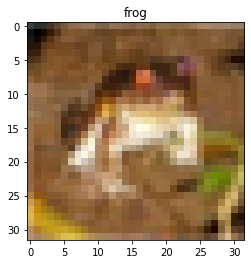

In [6]:
import matplotlib.pyplot as plt

def plotImage(index):
    label_name = labels
    image = data_batch_1['data'][index] # take first image
    label = data_batch_1['labels'][index] # take first image label index
    image = image.reshape(3,32,32) # Reshape the image
    image = image.transpose(1,2,0) # Transpose the image
    # Display the image: 
    plt.imshow(image)
    plt.title(label_name[label])
    
plotImage(0)

### Use SGDClassifier

Using SGD to create a binary classifier. Will classify images for label "2", which corresponds to birds. The model will classify if an image is a bird (true) or not a bird (false). Similar example given in chapter 2 of below textbook.

Citation: Aureilien Geiron. "Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems"

In [7]:
y_train_2 = (y_train == 2)  # True for all 2s, False for all other digits
y_test_2 = (y_test == 2)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(random_state=42)

2
bird
result:[ True]


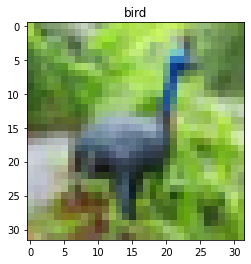

In [50]:
# example of predicting index 6 (a bird image)
some_digit = X[6] 
print(y[6])
print(labels[y[6]])

print('result:' + str(sgd_clf.predict([some_digit])))
plotImage(6)

The SGD classifier accurately predicts that index 6 is an image of a bird. SGD classifiers are typically faster than logistic regression and perform well for large datasets. The classifier wsa trained quickly.  

### Use k-fold Cross Validation (cross_val_score):

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring="accuracy")

array([0.85976753, 0.89163855, 0.89497374])

sklearn was utilized to calculate the cross validation scores. 

Adding more data:

In [11]:
# load the batches: 
for i in range(2,6):
    filepath = rootpath + '/data_batch_' + str(i)
    data_batch_n = unpickle(filepath)
    # append the images
    a = data_batch_n["data"]
    X = np.concatenate((X, a), axis=0)
    # append the labels
    b = data_batch_1['labels'] #array of labels: 10,000 long for each image
    b = np.array(b)
    b = b.astype(np.uint8)
    y = np.concatenate((y, b), axis=0)

# 50,000 images long:
print(X.shape)
print(y.shape)
# recreate train & test:
X_train, X_test, y_train, y_test = X[:45000], X[45000:], y[:45000], y[45000:]
y_train_2 = (y_train == 2)  # True for all 2s, False for all other digits
y_test_2 = (y_test == 2)
# retrain classifier:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_2)

(50000, 3072)
(50000,)


SGDClassifier(random_state=42)

In [12]:
cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring="accuracy")

array([0.88293333, 0.87873333, 0.8942    ])

CV= number of runs (3)
* 88.29% accuracy
* 87.87% accuracy
* 89.42% accuracy

Upon first glance, the accuracy of the model seemed really good for a model as quick as SGD. However since this is a binary classifier, simply answering "False" always would grant an accuracy rate of 90% on average. 

All the data batches were added into the test so the training data would have 45,000 images to train from instead of 8,000. The accuracy only improved slightly. We dropped the remaining images in order to get faster performance.

StratifiedKFold cross validation was used to further understand the innacuracies in our model.

### Use StratifiedKFold cross validation

In [13]:
# reset the data (10,000 images is faster)
X = data_batch_1["data"]   #shape: (10000, 3072)
y = data_batch_1['labels'] #array of labels: 10,000 long for each image
y = np.array(y)
y = y.astype(np.uint8)

X_train, X_test, y_train, y_test = X[:8000], X[8000:], y[:8000], y[8000:]
y_train_2 = (y_train == 2)  # True for all 2s, False for all other digits
y_test_2 = (y_test == 2)

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(random_state=42)

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# code utilized from chapter 3 of Hands on Machine Learning 
for train_index, test_index in skfolds.split(X_train, y_train_2):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_2[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_2[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  


0.865
0.895
0.75625
0.61875
0.8375
0.8375
0.8475
0.8775
0.8825
0.6425


After researching online, it was determined that 10 folds was the proper number of stratified cross folds for a dataset (Olsen). However since the dataset was relatively small (10000), 10 folds potentially may be too much. The stratified data shows better how our model can be very innacurate on small portions of data. But overall the accuracy scores seems a little lower than the expected 90%. Next we generate a confusion matrix to see how innacurate our model truly is. 

https://cran.r-project.org/web/packages/cvms/vignettes/picking_the_number_of_folds_for_cross-validation.html#:~:text=When%20performing%20cross%2Dvalidation%2C%20it,common%20to%20use%2010%20folds.

### Generate a confusion matrix:

In [15]:
# get list of predictions (will be used to generate the confusion matrix)
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_2, y_train_pred)

array([[7019,  164],
       [ 779,   38]], dtype=int64)

True negatives: 7019 <br>
False positives: 164 <br>
False negatives: 779 <br>
True positives: 38 <br>

The amount of False negatives is shockingly high, 779, versus the true positives of 38. In the MINST example in the book, the true positives were greater than the false negatives. A confusion matrix is an accurate way to see how the model performs. The overall number of positives in the dataset is overall very low. Meaning, the SGD classifier may have difficulty recogonizing images. Something like a nueral network or logistic regression may be needed to get better results. The images are also more complex than a black and white dataset (noise, color, etc.)

### ROC curve: 

Sklearn can be used to calculate the ROC curve yielding the False positive rate and True Positive Rate (recall). 

In [17]:
#compute y_scores using cross validation:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                             method="decision_function")

# compute necessary metrics for roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

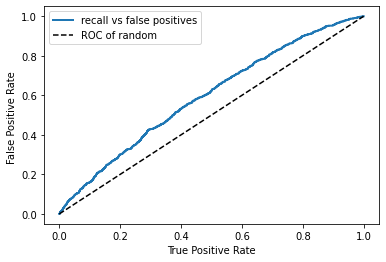

In [18]:
# graph ROC curve
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate ")
    plt.legend(['recall vs false positives','ROC of random'])


plot_roc_curve(fpr, tpr)
plt.show()

In [19]:
# Use roc to compute area under the curve (1 = perfect classifier; 0.5 = random)
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_2, y_scores))

0.5941065800166345


A score of 1.0 == perfect model; A score of 0.5 == random. The ROC curve may lend some more validity to our model proving that our model is better than random chance (0.60 score > 0.5). This graph shows the model is definitely not reliable to a high degree of precision, but it is much better than random chance by a significant margin.

Note: standard scaling was expiremented with, however the calculation did not converge

### use OvO or OvR classifier

Scikit Learn automatically chooses between One versus One (OvO) or One versus Rest (OvR) classifier. Scikit Learn chooses the more optimal choice

In [20]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([2], dtype=uint8)

Evaluating model's performance: 

In [21]:
# cross validation score
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.4431946 , 0.43644544, 0.44673668])

The results from the OvO/OvR classifier are relatively poor but a signifcant margin better than random guessing. The problem now complicates from a simple "True" or "False" to choosing an image. Random chance would be 10% but our classifier performed at above 40%. The image data is also more complex than to predict than something like the MINST dataset (color images, more noise, similar looking animals, etc.) For more precise results, logistic regression or a neural network should be used.

### Use sklearn.neighbors.KNeighborsClassifier 

KNeighborsClassifier will be used to predict for multiple classes. Two categories the cifar 10 dataset is concerned with is both "trucks" and "automobiles." Our K neighbor classifier will classify images for both the truck and autombile category as both "True" or "False". If our model is accurate enough, it will be able to tell the difference between trucks and automobiles. 

In [22]:
# True for all autombiles:
y_train_1 = (y_train == 1)
y_test_1 = (y_test == 1)
# True for all trucks:
y_train_8 = (y_train == 8)
y_test_8 = (y_test == 8)
# All cars multilabel:
y_multilabel = np.c_[y_train_1, y_train_8]
y_multilabel # truck and car label

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [23]:
from sklearn.neighbors import KNeighborsClassifier
# train the knn classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [24]:
# test the classifier
test_index = 15 #truck image
test_image = X[test_index]

knn_clf.predict([test_image])

array([[False,  True]])

The model predicts "False" for the automobile category and "True" for the truck category. Below is a rendering of the image, it is a truck. In this anecdotal case,the classifier was able to tell the difference between a truck and a car. 

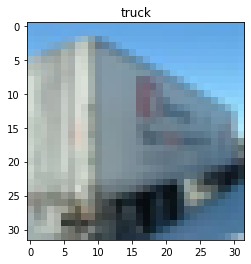

In [25]:
plotImage(15)

In [53]:
cross_val_score(knn_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.24287856, 0.23988006, 0.22522523])

Looking at the cross validation score, the scores are around (0.25). At first this score seems lower than before. However, the kneighbors classifier has to classify multiple classes correctly (both truck and autombile). This seems inline with random chance of guessing both classes (0.5 * 0.5 = 0.25).

### Use sklearn.ensamble.RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [55]:
cross_val_score(clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.35382309, 0.32683658, 0.33183183])

Using the random forest classifier, the cross validatgion scores are around 35%. This score is much better than random chance (10%) but worse than the OvO classifier (45%). The paramaters from the random forest classifier can be hyper tuned to increase the model's performance. Increasing the maximum depth to 10 helps improve the model performance greatly. 

### Use an ensembale of methods

From chapter 7 "ensembale learning." Bagging Classifier utilizes "soft voting"

In [46]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [44]:
cross_val_score(bag_clf, X_test, y_test, cv=3, scoring="accuracy")

array([0.31934033, 0.30284858, 0.31081081])

In [45]:
bag_clf.score

<bound method ClassifierMixin.score of BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)>

Bagging machine learning was utilized because it works well with "weak learning algorithms" based on our cross validation scores. The cross validation score can be seen that the model's performance was around 30%.

https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205